<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_3_Xmons_and_Resonators_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pylint: disable=invalid-name, line-too-long, missing-module-docstring
# flake8: noqa

# @title 1. Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

# @title 2. Clone Metal; bind to /content/qiskit-metal; headless, layout-only init
import os
import sys
import re
import textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH", ""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip() + "\n"  # Use a real newline character

(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(
        rndr_init.read_text(encoding="utf-8"), encoding="utf-8"
    )
    rndr_init.write_text(
        "# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
        encoding="utf-8"
    )

# Verify: import the package *from this folder* and keep it light
import importlib
import sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


# @title 3. Consolidated Imports (GDSTK-only, No PYEPR)
# (This cell combines all imports needed for the full design)

import os
import sys
import glob
import subprocess
os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")  # headless-safe

# ----- Strictly require GDSTK (not gdspy) -----
try:
    import gdstk  # noqa: F401
except ModuleNotFoundError:
    subprocess.check_call(
        [sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"]
    )
    import gdstk  # noqa: F401

# ----- Scientific stack -----
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Dict

# ----- Qiskit Metal imports (geometry library only) -----
from qiskit_metal import Dict as QmDict
from qiskit_metal.designs import DesignPlanar
from qiskit_metal.qlibrary.core import QComponent  # Added for type hinting

# Transmon cross
try:
    from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
except Exception:
    # Some clones use capitalized file names
    from qiskit_metal.qlibrary.qubits.TransmonCross import TransmonCross  # type: ignore

# Manhattan JJ (try common paths)
_jj_exc = None
try:
    from qiskit_metal.qlibrary.qubits.JJ_Manhattan import jj_manhattan
except Exception as _e1:
    _jj_exc = _e1
    try:
        from qiskit_metal.qlibrary.qubits.jj_manhattan import jj_manhattan  # fallback
    except Exception as _e2:
        _jj_exc = _e2
        try:
            # Some repos place it under components/junction
            from qiskit_metal.qlibrary.components.junction.jj_manhattan import jj_manhattan
        except Exception as _e3:
            raise ImportError(
                f"Could not import jj_manhattan from your clone. Last error: {_e3}\n"
                "Please locate the Manhattan JJ component in your qiskit_metal clone and adjust the import."
            )

# Terminations and T-Lines
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

# ----- Eradicate auto-renderers so pyEPR is never imported --
# This is your key requirement for a geometry-only flow.
from qiskit_metal import config as _metal_cfg
try:
    _metal_cfg.renderers_to_load.clear()
except Exception:
    pass

# ----- Hard sanity: neither gdspy nor pyEPR should be around --
assert "gdspy" not in sys.modules, "gdspy was imported; this pipeline must use gdstk only."
assert "pyEPR" not in sys.modules, "pyEPR was imported; this is a geometry-only pipeline."

plt.rcParams["figure.dpi"] = 120
print("Imports OK • Qiskit-Metal clone + GDSTK • Renderers disabled (no pyEPR).")


# @title 4. Consolidated Control Knobs (FIXED)
# ---------- Chip canvas ----------
CHIP_W_MM, CHIP_H_MM = 10.0, 10.0
CHIP_NAME = "main" # *** Added chip name variable for clarity ***

# ---------- Layers ----------
LAYER_METAL = 1          # positive metal (Qubits, Resonators, Feedline)
LAYER_JJ = 15            # e-beam JJ layer
LAYER_NEG = 10           # optional subtract/etch layer during export
INVERT_POLARITY = False

# ---------- X-mon capacitor ----------
CROSS_WIDTH_UM = 20.0
CROSS_LENGTH_UM = 200.0
CROSS_GAP_UM = 16.0
ORIENTATION_DEG = 0.0
CROSS_LENGTH_SCALE = [0.94, 1.00, 1.06]

# ---------- Manhattan JJ placement ----------
JJ_LAYER = LAYER_JJ
JJ_POS_TWEAK_UM = (-35.0, -18.0)
JJ_ORIENT_OFFSET_DEG = 90.0

# ---------- Array placement ----------
N_QUBITS = 3
ROW_Y_MM = 0.0
START_X_MM = -3.0
PITCH_X_MM = 3.2

# ---------- Feedline ----------
FEED_Y_MM = 2.0  # Y position of the feedline centerline
FEED_START_X_MM = -4.5  # Start X coord
FEED_END_X_MM = 4.5  # End X coord
FEED_WIDTH_UM = 10.0  # Feedline CPW width
FEED_GAP_UM = 6.0  # Feedline CPW gap to ground

# ---------- Launch Pads ----------
LAUNCHPADS_ACTIVE = True  # Set to True to add launchpads
LPAD_PAD_WIDTH_UM = 300.0
LPAD_TAPER_HEIGHT_UM = 300.0
LPAD_PAD_HEIGHT_UM = 240.0
LPAD_PAD_GAP_UM = 144.0
LPAD_LEAD_LEN_UM = 50.0  # Launchpad's internal lead length

# ---------- CPW Meandering Resonators ----------
RES_WIDTH_UM = 10.0  # Resonator CPW width
RES_GAP_UM = 6.0  # Resonator CPW gap to ground
RES_LAYER = LAYER_METAL
RES_LENGTH_MM = 6.0  # Target total length of the meander centerline
RES_MEANDER_RADIUS_UM = 150.0  # Meander bend radius
RES_COUPLING_GAP_UM = 10.0  # Gap between resonator end and feedline

# *** This is the correct pin name for TransmonCross ***
# Where resonator connects to qubit (using "North" arm pin)
QUBIT_READOUT_PIN = 'a'

# ---------- Export ----------
GDS_OUT = "/content/chip_3q_3r_feedline_gdstk.gds"


# @title 5. Consolidated Helper Functions (PEP 257)
# (This cell combines all helper functions from the notebook)

def um(v: float) -> str:
    """Convert a float to a Qiskit-Metal micrometer string.

    Args:
        v: The value in micrometers.

    Returns:
        A string formatted for Qiskit-Metal, e.g., '25um'.
    """
    return f"{v:.6g}um"


def mm(v: float) -> str:
    """Convert a float to a Qiskit-Metal millimeter string.

    Args:
        v: The value in millimeters.

    Returns:
        A string formatted for Qiskit-Metal, e.g., '3.2mm'.
    """
    return f"{v:.6g}mm"


def make_geometry_only_design() -> DesignPlanar:
    """Create a headless DesignPlanar with renderers disabled.

    Returns:
        A new DesignPlanar instance ready for geometry-only work.
    """
    return DesignPlanar(enable_renderers=False, overwrite_enabled=True)


def xmon_south_gap_pose(design: DesignPlanar, q: TransmonCross) -> Tuple[float, float, float]:
    """Calculate the pose for a JJ in the X-mon's south gap.

    Args:
        design: The Qiskit Metal design object.
        q: The TransmonCross component.

    Returns:
        A tuple of (x_mm, y_mm, orient_deg) for the JJ.
    """
    L = float(design.parse_value(q.options.cross_length))  # mm
    g = float(design.parse_value(q.options.cross_gap))     # mm
    x0 = float(design.parse_value(q.options.pos_x))
    y0 = float(design.parse_value(q.options.pos_y))
    theta = float(q.options.orientation) if "orientation" in q.options else 0.0  # deg

    # Center of the south arm gap at y = -(L + g/2) in local coords
    local = np.array([0.0, -(L + 0.5 * g)], dtype=float)

    # Rotate by theta (deg) and translate to (x0, y0)
    t = np.deg2rad(theta)
    R = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t),  np.cos(t)]], dtype=float)
    px, py = (np.array([x0, y0]) + R @ local)

    # Fine-tune in µm -> mm
    px += JJ_POS_TWEAK_UM[0] / 1000.0
    py += JJ_POS_TWEAK_UM[1] / 1000.0

    # Orient JJ along the local south axis: rotate Manhattan JJ by theta + offset
    phi = theta + JJ_ORIENT_OFFSET_DEG
    return px, py, phi


def add_manhattan_jj_at_south(design: DesignPlanar, q: TransmonCross, name: str) -> QComponent:
    """Create a Manhattan JJ at the south gap of a given X-mon.

    Args:
        design: The Qiskit Metal design object.
        q: The TransmonCross component.
        name: The name for the new JJ component.

    Returns:
        The created jj_manhattan component.
    """
    x_mm, y_mm, phi_deg = xmon_south_gap_pose(design, q)
    jj_opts = dict(
        pos_x=mm(x_mm),
        pos_y=mm(y_mm),
        orientation=str(phi_deg),
        layer=JJ_LAYER,
        chip=CHIP_NAME,  # *** Explicitly assign chip ***
    )
    jj = jj_manhattan(design, name=name, options=jj_opts)
    return jj


def _plot_qgeometry_outline(design: DesignPlanar, ax, linewidth=0.35, show_holes=True):
    """Internal helper to plot Shapely geometry outlines onto a Matplotlib axis."""
    polys = design.qgeometry.tables.get("poly")
    if isinstance(polys, pd.DataFrame) and len(polys):
        for _, row in polys.iterrows():
            g = row.geometry
            if g is None:
                continue
            geoms = getattr(g, "geoms", [g])
            for pg in geoms:
                if not hasattr(pg, "exterior"):
                    continue
                x, y = pg.exterior.coords.xy
                ax.plot(x, y, linewidth=linewidth)
                if show_holes:
                    for hole in getattr(pg, "interiors", []):
                        hx, hy = hole.coords.xy
                        ax.plot(hx, hy, linewidth=max(0.1, 0.5 * linewidth))

    paths = design.qgeometry.tables.get("path")
    if isinstance(paths, pd.DataFrame) and len(paths):
        for _, row in paths.iterrows():
            g = row.geometry
            if g is None:
                continue
            geoms = getattr(g, "geoms", [g])
            for ln in geoms:
                x, y = ln.coords.xy
                ax.plot(x, y, linewidth=linewidth)


def preview_design_matplotlib(design: DesignPlanar,
                                dpi_onscreen: int = 150,
                                figsize: Tuple[float, float] = (9, 9),
                                linewidth: float = 0.35,
                                show_holes: bool = True):
    """Generate a Matplotlib preview of the design's qgeometry.

    Args:
        design: The Qiskit Metal design object.
        dpi_onscreen: The DPI for the rendered figure.
        figsize: The figure size (width, height) in inches.
        linewidth: The linewidth for plotting outlines.
        show_holes: Whether to render polygon interiors (holes).
    """
    tables = design.qgeometry.tables
    poly_df = tables.get("poly")
    path_df = tables.get("path")
    n_poly = (0 if not isinstance(poly_df, pd.DataFrame) else len(poly_df))
    n_path = (0 if not isinstance(path_df, pd.DataFrame) else len(path_df))
    print(f"[diag] qgeometry counts — poly={n_poly}, path={n_path}")

    plt.close("all")
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi_onscreen)
    _plot_qgeometry_outline(design, ax, linewidth=linewidth, show_holes=show_holes)
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_title("3× Xmon + JJs + 3× Meander Resonators + Feedline")
    fig.tight_layout()
    plt.show()


def get_cpw_options(width_um: float, gap_um: float, layer: int) -> QmDict:
    """Create a QmDict of standard CPW options.

    Args:
        width_um: The trace width in micrometers.
        gap_um: The trace gap in micrometers.
        layer: The GDS layer number.

    Returns:
        A QmDict with trace_width, trace_gap, and layer.
    """
    return QmDict(
        trace_width=um(width_um),
        trace_gap=um(gap_um),
        layer=layer
    )


print("Helper functions defined.")


# @title 6. Build Full Geometry (Fixed Pin Routing)
# (This build script is corrected to use 'a' pin and assign all components to a chip)

design = make_geometry_only_design()

# --- Canvas extents ---
chip = design.chips[CHIP_NAME]
chip.size["size_x"] = mm(CHIP_W_MM)
chip.size["size_y"] = mm(CHIP_H_MM)

# --- Define common CPW options ---
feedline_cpw_opts = get_cpw_options(FEED_WIDTH_UM, FEED_GAP_UM, LAYER_METAL)
resonator_cpw_opts = get_cpw_options(RES_WIDTH_UM, RES_GAP_UM, RES_LAYER)

# --- 1. Create Non-Routing Components ---

# --- Three X-mon qubits ---
xmons: List[TransmonCross] = []
for i in range(N_QUBITS):
    pos_x = START_X_MM + i * PITCH_X_MM
    scale = CROSS_LENGTH_SCALE[i]
    q_opts = dict(
        pos_x=mm(pos_x),
        pos_y=mm(ROW_Y_MM),
        orientation=str(ORIENTATION_DEG),
        cross_width=um(CROSS_WIDTH_UM),
        cross_gap=um(CROSS_GAP_UM),
        cross_length=um(CROSS_LENGTH_UM * scale),
        layer=LAYER_METAL,
        chip=CHIP_NAME  # *** THE FIX: Explicitly assign chip ***
    )
    q = TransmonCross(design, name=f"Q{i}", options=q_opts)
    xmons.append(q)

# --- Real Manhattan JJs at each X-mon south gap ---
jjs = []
for i, q in enumerate(xmons):
    # This helper function already assigns chip="main"
    jj = add_manhattan_jj_at_south(design, q, name=f"JJ{i}")
    jjs.append(jj)

# --- Launch Pads (Instantiate at correct positions) ---
launchpads = []
lp_left = None
lp_right = None
if LAUNCHPADS_ACTIVE:
    lp_opts_base = QmDict(
        pad_width=um(LPAD_PAD_WIDTH_UM),
        pad_height=um(LPAD_PAD_HEIGHT_UM),
        pad_gap=um(LPAD_PAD_GAP_UM),
        taper_height=um(LPAD_TAPER_HEIGHT_UM),
        lead_length=um(LPAD_LEAD_LEN_UM),
        trace_width=feedline_cpw_opts.trace_width,
        trace_gap=feedline_cpw_opts.trace_gap,
        layer=LAYER_METAL,
        chip=CHIP_NAME  # *** THE FIX: Explicitly assign chip ***
    )
    # Place Left Launchpad, oriented 0 degrees (pin 'tie' points right)
    lp_left = LaunchpadWirebond(design, "LP_Left", options=QmDict(
        pos_x=mm(FEED_START_X_MM), pos_y=mm(FEED_Y_MM), orientation='0', **lp_opts_base
    ))
    # Place Right Launchpad, oriented 180 degrees (pin 'tie' points left)
    lp_right = LaunchpadWirebond(design, "LP_Right", options=QmDict(
        pos_x=mm(FEED_END_X_MM), pos_y=mm(FEED_Y_MM), orientation='180', **lp_opts_base
    ))
    launchpads.extend([lp_left, lp_right])

# --- Resonator Terminations (Open to Ground) ---
terminations = []
for i, q in enumerate(xmons):
    q_x = float(design.parse_value(q.options.pos_x))
    # Calculate Y-position for the termination pin
    term_y = FEED_Y_MM - float(design.parse_value(feedline_cpw_opts.trace_width)) / 2000.0 \
                       - float(design.parse_value(feedline_cpw_opts.trace_gap)) / 1000.0 \
                       - RES_COUPLING_GAP_UM / 1000.0 \
                       - float(design.parse_value(resonator_cpw_opts.trace_width)) / 2000.0
    term_opts = QmDict(
        pos_x=mm(q_x), pos_y=mm(term_y), orientation='90',  # 90 deg = pin 'open' points up
        layer=RES_LAYER, width=resonator_cpw_opts.trace_width,
        chip=CHIP_NAME  # *** THE FIX: Explicitly assign chip ***
    )
    term = OpenToGround(design, f"Term{i}", options=term_opts)
    terminations.append(term)

# --- 2. First Rebuild: Generate Geometry & Pins for all non-routing components ---
print("Running first rebuild to generate pins...")
design.rebuild()
print("First rebuild complete.")

# --- DEBUG: Check pin names AFTER first rebuild ---
try:
    q0 = design.components['Q0']
    print(f"DEBUG (Post-Rebuild): Pin names for {q0.name}: {list(q0.pins.keys())}")
except KeyError:
    print("DEBUG: Component Q0 not found after first rebuild.")
# --- END DEBUG ---

# --- 3. Create Routing Components (Feedline & Resonators) ---

# --- Straight Feedline (Connects directly to Launchpad pins) ---
feedline = None
if LAUNCHPADS_ACTIVE and lp_left and lp_right:
    feed_opts = QmDict(
        pin_inputs=QmDict(
            start_pin=QmDict(component=lp_left.name, pin='tie'),
            end_pin=QmDict(component=lp_right.name, pin='tie')
        ),
        **feedline_cpw_opts
    )
    # Route* components infer chip from pins, so 'chip' is not needed here
    feedline = RouteStraight(design, name="Feedline", options=feed_opts)
else:
    print("WARNING: Launchpads not active, Feedline not created.")

# --- Meandering Resonators (Connects Qubit 'a' to Termination 'open') ---
resonators = []
for i, q in enumerate(xmons):
    term = terminations[i]  # Get the corresponding termination object
    meander_opts = QmDict(
        pin_inputs=QmDict(
            start_pin=QmDict(component=q.name, pin=QUBIT_READOUT_PIN),  # Uses 'a'
            end_pin=QmDict(component=term.name, pin='open')
        ),
        total_length=mm(RES_LENGTH_MM),
        meander=QmDict(
            radius=um(RES_MEANDER_RADIUS_UM),
            spacing=um(RES_MEANDER_RADIUS_UM * 2 + RES_GAP_UM * 2 + RES_WIDTH_UM),
            asymmetry='0um'
        ),
        lead=QmDict(start_straight='50um', end_straight='50um'),
        fillet='99um',
        **resonator_cpw_opts
    )
    try:
        resonator = RouteMeander(design, f"Res{i}", options=meander_opts)
        resonators.append(resonator)
    except Exception as e:
        # This will catch errors if the 'a' pin somehow still doesn't exist
        print(f"ERROR creating Res{i}: {e}")

# --- 4. Final Rebuild: Generate routing geometry ---
print("Running final rebuild for routing components...")
design.rebuild()
print("Final rebuild complete.")

# --- Print components and preview ---
print("Components:", sorted(list(design.components.keys())))
preview_design_matplotlib(design, dpi_onscreen=150)  # Use 150 DPI for a clear image


# @title 7. GDSTK Export Function (PEP 257)
# (This is the GDSTK-specific exporter from your original notebook)

def _coords_as_array(pg):
    """Return (outer, holes) arrays from a Shapely Polygon."""
    ox, oy = pg.exterior.coords.xy
    outer = np.column_stack([np.asarray(ox), np.asarray(oy)])
    holes = []
    for interior in getattr(pg, "interiors", []):
        hx, hy = interior.coords.xy
        holes.append(np.column_stack([np.asarray(hx), np.asarray(hy)]))
    return outer, holes


def _to_mm(val, design):
    """Parse a numeric-or-string width to mm."""
    if isinstance(val, str):
        return float(design.parse_value(val))  # returns mm
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return 0.0
    return float(val)


def export_design_to_gdstk(
    design: DesignPlanar,
    out_path: str,
    unit_m: float = 1e-6,
    layer_for_neg: Optional[int] = None,
    assume_mm: bool = True,
    boolean_precision: float = 1e-3,
    paths_as_polygons: bool = False
) -> None:
    """Export qgeometry (poly + path) to a GDS file using GDSTK.

    This function handles:
    - Scaling from design units (mm) to GDS user units (default µm).
    - Converting Shapely Polygons with holes into GDS-compatible polygons
      using GDSTK's boolean 'not' operation.
    - Converting Qiskit Metal paths (Shapely LineStrings) into
      GDSTK FlexPath objects.

    Args:
        design: The Qiskit Metal design object.
        out_path: The file path for the output GDS file.
        unit_m: The GDS unit in meters (default 1e-6 for 1µm).
        layer_for_neg: A specific layer to move 'subtract' polygons to.
        assume_mm: Assume qgeometry units are millimeters (default True).
        boolean_precision: Precision for boolean operations (in GDS units).
        paths_as_polygons: Convert FlexPaths to Polygons (default False).
    """
    lib = gdstk.Library(unit=unit_m, precision=1e-9)
    top = gdstk.Cell("TOP")
    lib.add(top)

    # If design is in mm and GDS unit is µm, scale=1000
    scale = 1000.0 if assume_mm and math.isclose(unit_m, 1e-6) else 1.0

    # -------- POLYGONS --------
    polys = design.qgeometry.tables.get("poly")
    if isinstance(polys, pd.DataFrame) and len(polys):
        for _, row in polys.iterrows():
            geom = row.geometry
            if geom is None:
                continue

            lyr = int(row.get("layer", LAYER_METAL))
            subtract = bool(row.get("subtract", False))
            dest_layer = (
                layer_for_neg if (subtract and layer_for_neg is not None) else lyr
            )

            geoms = getattr(geom, "geoms", [geom])
            for pg in geoms:
                if not hasattr(pg, "exterior"):
                    continue
                outer, holes = _coords_as_array(pg)
                outer *= scale
                holes = [h * scale for h in holes] if holes else []

                if holes:
                    # GDS requires boolean ops to represent holes
                    result = gdstk.boolean([outer], holes, "not",
                                           precision=boolean_precision,
                                           layer=dest_layer, datatype=0)
                    for poly in result:
                        top.add(poly)
                else:
                    top.add(gdstk.Polygon(outer, layer=dest_layer, datatype=0))

    # -------- PATHS (from RouteMeander, RouteStraight) --------
    paths = design.qgeometry.tables.get("path")
    if isinstance(paths, pd.DataFrame) and len(paths):
        for _, row in paths.iterrows():
            geom = row.geometry
            if geom is None:
                continue

            lyr = int(row.get("layer", LAYER_METAL))
            width_mm = _to_mm(row.get("width", 0.01), design)
            width_user = width_mm * scale  # Scale width to GDS units

            geoms = getattr(geom, "geoms", [geom])
            for ln in geoms:
                x, y = ln.coords.xy
                pts = np.column_stack([np.asarray(x), np.asarray(y)]) * scale
                # Create a FlexPath object
                fp = gdstk.FlexPath(pts, width_user, layer=lyr, datatype=0)
                if paths_as_polygons:
                    for poly in fp.to_polygons():
                        poly.layer = lyr
                        top.add(poly)
                else:
                    # Add the path object directly
                    top.add(fp)

    lib.write_gds(out_path)
    print(f"[GDSTK] Wrote: {out_path}")


print("GDSTK export function defined.")


# @title 8. Run Exporter and Download
# (This cell runs the export function and triggers a download in Colab)

try:
    export_design_to_gdstk(
        design,
        GDS_OUT,  # Use the updated output filename
        unit_m=1e-6,  # user unit = µm
        layer_for_neg=(LAYER_NEG if not INVERT_POLARITY else None),
        assume_mm=True,
        boolean_precision=1e-3,  # 1nm precision if user unit is 1um
        paths_as_polygons=False  # Keep as GDS PATH elements
    )

    # Optional: Download the GDS file from Colab
    from google.colab import files
    files.download(GDS_OUT)

except NameError as e:
    print(f"Export failed. Was the design built? Error: {e}")
except ImportError:
    print(f"Not in Colab environment. File saved to: {GDS_OUT}")
except Exception as e:
    print(f"An error occurred during export: {e}")


# @title 9. GDSTK Matplotlib Preview (800 DPI)
import gdstk
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import os

# Ensure matplotlib is in the right mode for Colab
%matplotlib inline

print("--- GDSTK Matplotlib Preview ---")
# Check if the GDS file from the previous step exists
# GDS_OUT is defined in cell 4
if 'GDS_OUT' in locals() and os.path.exists(GDS_OUT):
    print(f"Loading '{GDS_OUT}' for high-resolution preview...")

    try:
        lib = gdstk.read_gds(GDS_OUT)
        top_cell = lib.top_level()[0]

        # Get all polygons from the cell (e.g., qubits, pads, JJ pads)
        all_polys = top_cell.get_polygons(by_spec=True)
        # Get all paths from the cell (e.g., feedline, resonators)
        all_paths = top_cell.get_paths()

        plt.close('all')
        # Create a Matplotlib figure with 800 DPI
        fig, ax = plt.subplots(figsize=(8, 8), dpi=800)
        ax.set_aspect('equal')
        ax.set_facecolor('k') # Black background like KLayout

        # Plot Polygons
        for (layer, datatype), polygons in all_polys.items():
            # Use layer number to cycle through default colors
            color = f'C{layer % 10}'
            for poly_points in polygons:
                # Create a matplotlib Polygon patch
                patch = MplPolygon(poly_points, closed=True, facecolor=color, edgecolor=color, linewidth=0.1)
                ax.add_patch(patch)

        # Plot Paths (by converting them to polygons)
        for path in all_paths:
            # FlexPath.to_polygons() converts it to shapes
            for (layer, datatype), polygons in path.to_polygons(by_spec=True).items():
                color = f'C{layer % 10}'
                for poly_points in polygons:
                    patch = MplPolygon(poly_points, closed=True, facecolor=color, edgecolor=color, linewidth=0.1)
                    ax.add_patch(patch)

        # Auto-set view limits based on plotted geometry
        ax.autoscale_view()

        # Add labels (GDS units are in µm as per the export function)
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")
        ax.set_title(f"GDSTK Layout Preview (800 DPI) - {os.path.basename(GDS_OUT)}")
        fig.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting the GDSTK layout: {e}")

else:
    print(f"File not found or GDS_OUT variable not set. Skipping GDSTK preview.")
    if 'GDS_OUT' in locals():
        print(f"Path not found: {GDS_OUT}")
    else:
        print("Variable 'GDS_OUT' not defined.")

The meandering resonator code is in progress...

[load] Reading: /content/chip_3q_3r_feedline_gdstk.gds
[info] Auto-picked top cell: TOP
[info] Bounds (µm): x[-5184.000, 5184.000], y[-238.000, 2294.000]
[save] Saving preview: /content/chip_3q_3r_feedline_gdstk_preview_1200dpi.png


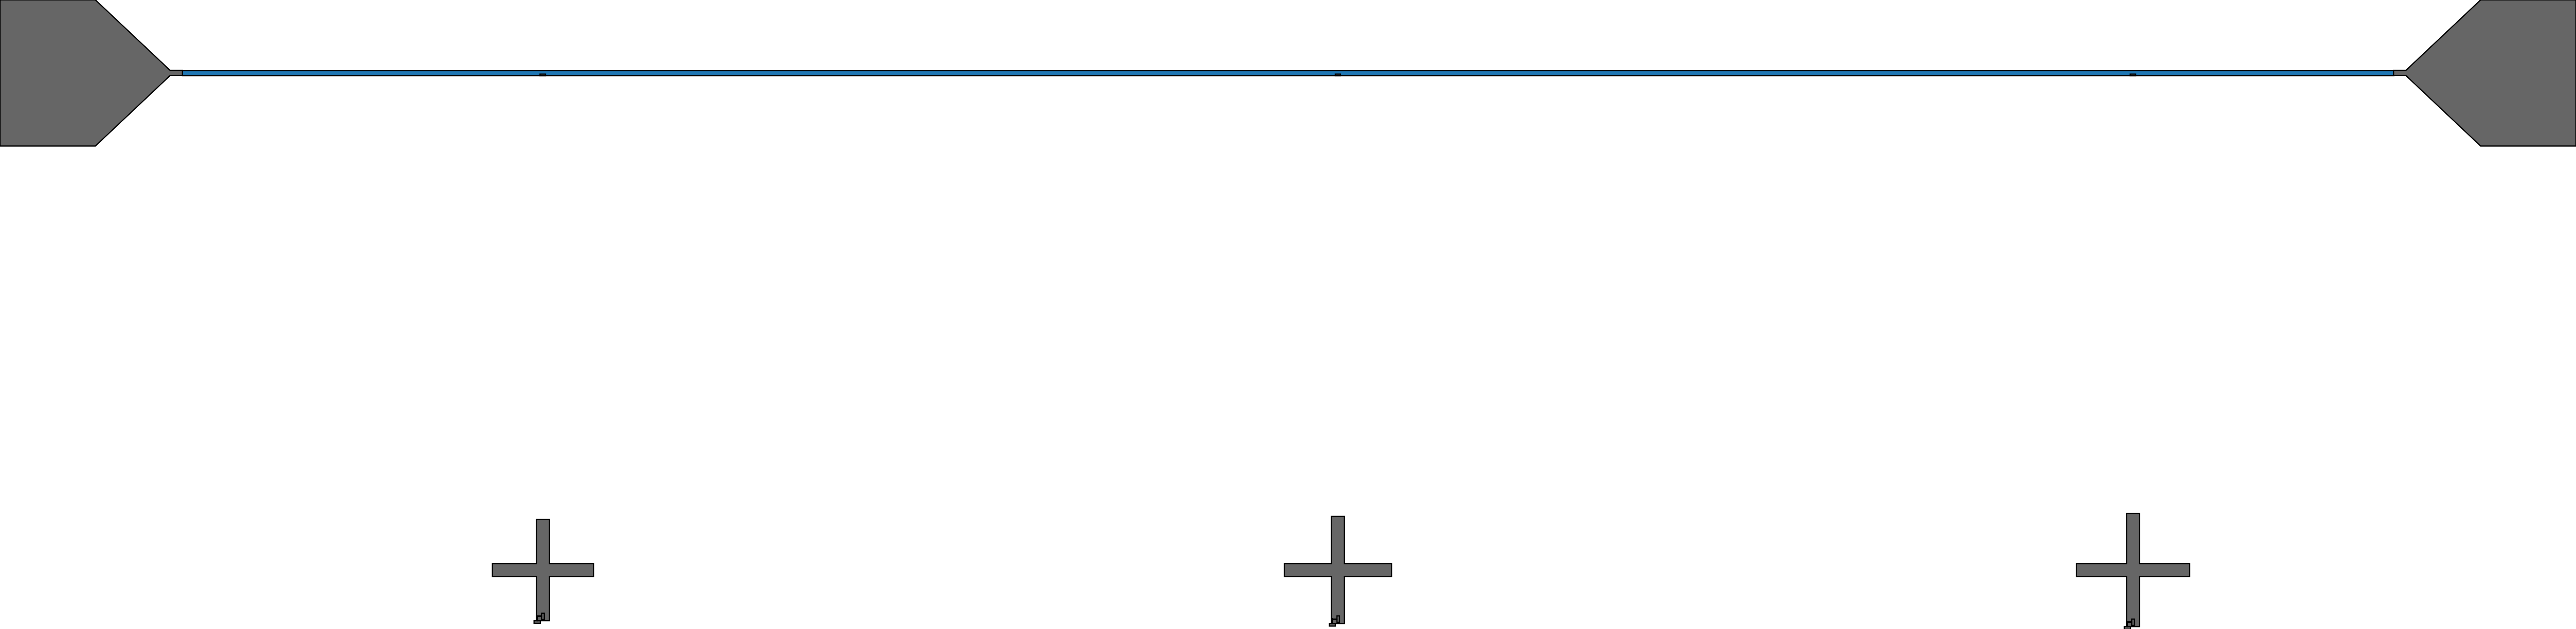

In [ ]:
#@title Preview GDS inline
import os, glob, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from IPython.display import display, Image
import gdstk

# ----- knobs you can tweak -----
GDS_PATH      = globals().get("GDS_OUT", "/content/chip_3q_3r_feedline_gdstk.gds")  # reuse if set
TOP_CELL_NAME = globals().get("GDS_TOP_CELL", None)                                 # reuse if set
DPI           = 1200
FIG_WIDTH_IN  = 8.0
LINEWIDTH_PT  = 0.20
BG_COLOR      = "white"

# Layer colors (extend as needed)
LAYER_GROUND  = 2
LAYER_METAL   = 1
LAYER_COLOR   = {LAYER_GROUND: "#d9dee7", LAYER_METAL: "#1f77b4"}

def _pick_cell(lib, name=None):
    if name and name in [c.name for c in lib.cells]:
        print(f"[info] Using requested cell: {name}")
        return lib[name]
    tops = lib.top_level()
    if not tops:
        raise RuntimeError("No top-level cells in library.")
    print(f"[info] Auto-picked top cell: {tops[0].name}")
    return tops[0]

def _polys_by_layer(cell):
    # include_paths=True expands PATHs to polygons; apply_repetitions=True follows array/repetition
    polys = cell.get_polygons(apply_repetitions=True, include_paths=True, depth=None)
    by_layer, xs, ys = {}, [], []
    for p in polys:  # gdstk.Polygon objects
        layer = int(getattr(p, "layer", 0))
        pts = np.asarray(p.points, dtype=float)
        by_layer.setdefault(layer, []).append(pts)
        xs.append(pts[:, 0]); ys.append(pts[:, 1])
    if not xs:
        raise RuntimeError("Found no polygons to plot (empty cell?).")
    xs = np.concatenate(xs); ys = np.concatenate(ys)
    return by_layer, (float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max()))

def save_and_show(gds_path, top_cell_name=None, dpi=DPI, fig_w_in=FIG_WIDTH_IN, lw_pt=LINEWIDTH_PT):
    if not os.path.exists(gds_path):
        # try last written .gds in /content
        cand = sorted(glob.glob("/content/*.gds"), key=os.path.getmtime)[-1:] or []
        if not cand:
            raise FileNotFoundError(f"GDS not found: {gds_path}")
        print(f"[warn] {gds_path} not found. Using most recent: {cand[0]}")
        gds_path = cand[0]

    print(f"[load] Reading: {gds_path}")
    lib  = gdstk.read_gds(gds_path)                            # loads the library
    cell = _pick_cell(lib, top_cell_name)                      # choose cell
    by_layer, (minx, miny, maxx, maxy) = _polys_by_layer(cell)      # collect polys + bounds
    print(f"[info] Bounds (µm): x[{minx:.3f}, {maxx:.3f}], y[{miny:.3f}, {maxy:.3f}]")

    w_um = maxx - minx; h_um = maxy - miny
    aspect = w_um / max(h_um, 1e-12); fig_h_in = fig_w_in / aspect

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_facecolor(BG_COLOR); ax.axis("off")

    # Draw ground first, then metal, then others for determinism
    draw_order = sorted(by_layer.keys(), key=lambda L: (L != LAYER_GROUND, L))
    for layer in draw_order:
        face = LAYER_COLOR.get(layer, "#666666")
        for pts in by_layer[layer]:
            ax.add_patch(MplPolygon(pts, closed=True, facecolor=face, edgecolor="black",
                                    linewidth=lw_pt, antialiased=True))

    root, _ = os.path.splitext(gds_path)
    out_png = f"{root}_preview_{dpi}dpi.png"

    # --- START FIX ---
    # 1. Save the figure to the file *first*
    print(f"[save] Saving preview: {out_png}")
    fig.savefig(out_png, dpi=dpi, bbox_inches='tight', pad_inches=0, facecolor=BG_COLOR)

    # 2. Close the figure to prevent matplotlib from *also* displaying it
    plt.close(fig)
    # --- END FIX ---

    # Show inline in the notebook (this now works because the file exists)
    display(Image(filename=out_png))
    return out_png

png_path = save_and_show(GDS_PATH, top_cell_name=TOP_CELL_NAME)